## This is a Julia version of the code for Einstein_Scalar_field

See paper: *On free evolution of self gravitating, spherically symmetric waves.*

Equations in notes.ipynb

In [1]:
using OrdinaryDiffEq
using SummationByPartsOperators
#using DifferentialEquations
using Plots
using LinearAlgebra
#using BandedMatrices
using Printf


In [33]:
include("aux_functions_IR.jl")

constraints!

In [34]:
N = 4001 #grid steps
x_i = 1.0; x_f = 100.0 #region 
dx = (x_f-x_i)/(N-1)
U = 5 #number of fields (f,g,h,χ_+,χ_-)

u0 = zeros(N*U) # for the initial data
du = zeros(N*U) # for the time derivatives
C = ones(2N) # for the constraints

D = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=4, xmin=x_i, xmax=x_f, N=N)

x = SummationByPartsOperators.grid(D)

Δ = dissipation_operator(D)
#Δ = 1.0
dT = 1.0*D.Δx
@show dx - D.Δx

dx - D.Δx = 0.0


0.0

In [35]:
# put some boundary data
A = 1.0; ω = 2π; τ = 5.0; σ = -0.1
p = (D, Δ, x, dx, A, ω, τ, σ)

f = @view u0[1:N]
g = @view u0[N+1:2N]
h = @view u0[2N+1:3N]
χ₊ = @view u0[3N+1:4N]
χ₋ = @view u0[4N+1:5N]

f .= 1.0;
g .= 1.0;
#rest set to zero

D*f

Δ*f

p

(SBP first-derivative operator of order 4 on a grid in [1.0, 100.0] using 4001 nodes 
and coefficients of Mattsson, Nordström (2004) 
  Summation by parts operators for finite difference approximations of second 
    derivatives. 
  Journal of Computational Physics 199, pp. 503-540., SBP 4-derivative dissipation operator of order 2 on a grid in [1.0, 100.0] using 4001 nodes 
and coefficients of Mattsson, Svärd, Nordström (2004) 
  Stable and Accurate Artificial Dissipation. 
  Journal of Scientific Computing 21.1, pp. 57-79. 
See also (first and second derivatives) 
  Mattsson, Nordström (2004) 
  Summation by parts operators for finite difference approximations of second 
    derivatives. 
  Journal of Computational Physics 199, pp. 503-540., 1.0:0.02475:100.0, 0.02475, 1.0, 6.283185307179586, 5.0, -0.1)

In [36]:
T=200
prob = ODEProblem(F!,u0,(0.0,T),p);
sol = solve(prob,RK4(),dt=dT,adaptive=false);#,save_everystep=false);

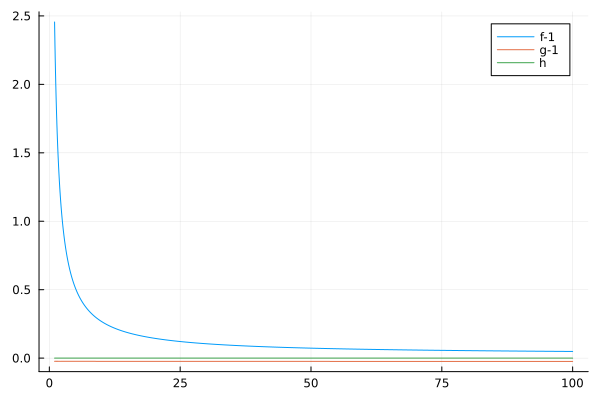

In [40]:
t = 200
plot(x,sol(t)[1:N].-1.0, label = "f-1")
plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
plot!(x,sol(t)[2N+1:3N], label = "h")

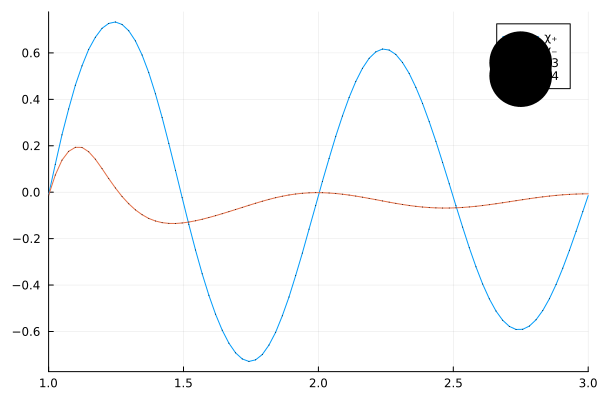

In [43]:
t = 100
plot(x,sol(t)[3N+1:4N], label = "χ₊"
,xlim = (1,3)
)
plot!(x,sol(t)[4N+1:5N], label = "χ₋")
scatter!(x,sol(t)[3N+1:4N],ms=0.1)
scatter!(x,sol(t)[4N+1:5N],ms=0.1)

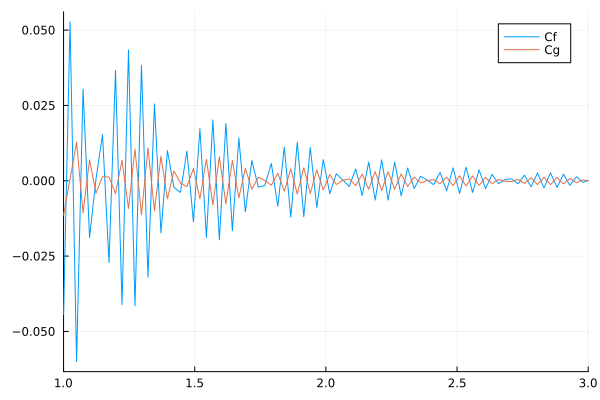

In [47]:
t = 200
constraints!(C,sol(t),D)
plot(x,C[1:N], label = "Cf"
, xlim = (1,3))
plot!(x,C[N+1:2N], label = "Cg")

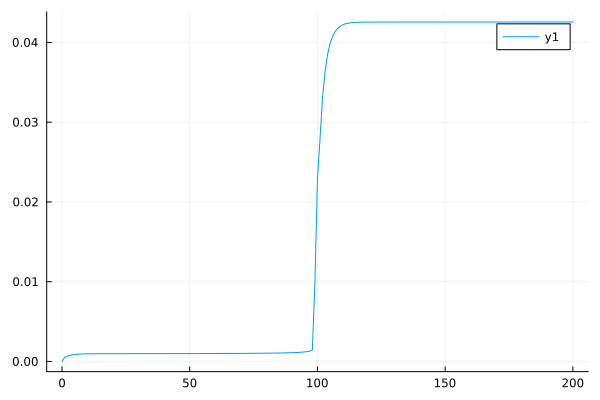

In [48]:
CC(t) = norm(constraints!(C,sol(t),D))
plot(0:T,t->CC(t))

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/fgh_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/fgh_fps5.gif")
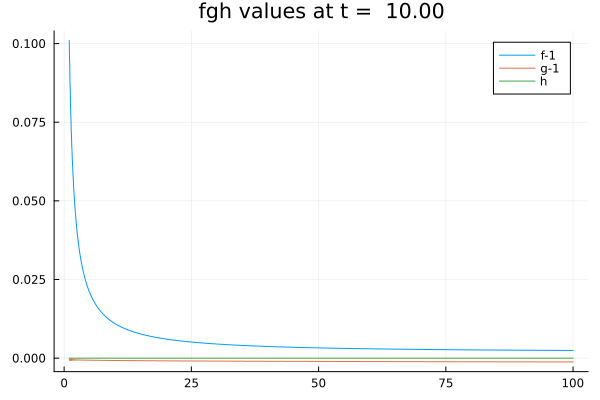

In [16]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title=@sprintf("fgh values at t = %6.2f",t))
    #@sprintf("\$t = %6.2f \$", sol.t[idx])
    plot!(x,sol(t)[1:N].-1.0, label = "f-1")
    plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
    plot!(x,sol(t)[2N+1:3N], label = "h")
end

gif(anim, "fgh_fps5.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif")
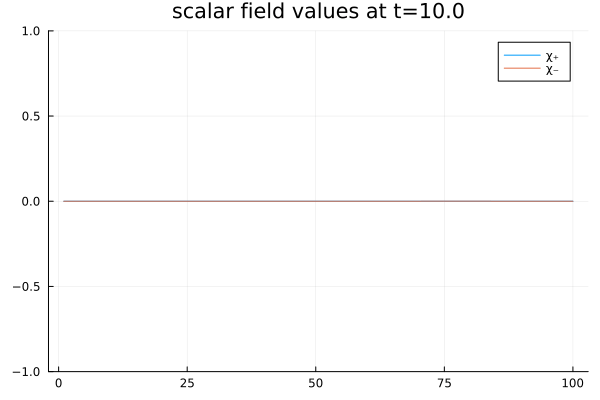

In [17]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="scalar field values at t=$t", ylim=(-1,1))
    plot!(x,sol(t)[3N+1:4N], label = "χ₊")
    plot!(x,sol(t)[4N+1:5N], label = "χ₋")
end

gif(anim, "scalar_fps5.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif")
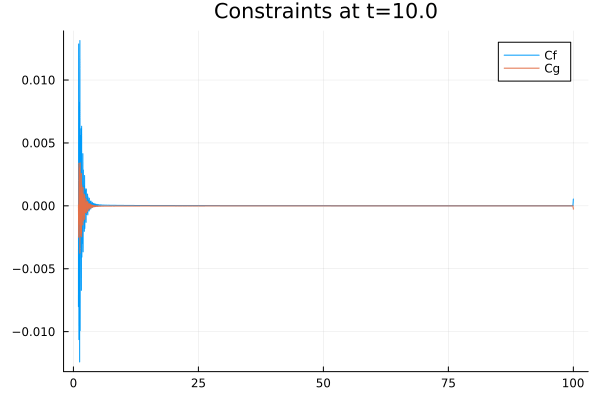

In [18]:
C = zeros(2N)
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="Constraints at t=$t")#, ylim=(-1,1))
    constraints!(C,sol(t),D)
    plot!(x,C[1:N], label = "Cf")
    plot!(x,C[N+1:2N], label = "Cg")
end

gif(anim, "scalar_fps5.gif", fps = 5)

In [14]:
D1 = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=2, xmin=0, xmax=1, N=3)
left_boundary_weight(D1)

0.25

In [15]:
D4 = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=4, xmin=0, xmax=1, N=3)
left_boundary_weight(D4)*2*48/17

DimensionMismatch: DimensionMismatch: length(grid) > LowerOffset + UpperOffset must hold. Got
length(grid) => 3
LowerOffset + UpperOffset => 4

In [16]:
a = [1,2]
b = @view a[:]
b .= [3,4]
a

2-element Vector{Int64}:
 3
 4

In [17]:
a = [1,2]
b = a
b .= [3,4]


2-element Vector{Int64}:
 3
 4

In [18]:
a

2-element Vector{Int64}:
 3
 4